In [1]:
import pandas as pd

data = pd.read_csv('./model_input.csv')

In [2]:
data.head(5)

,Unnamed: 0,reservation_id,locaion_id,party_size,high_chair_size,reservation_time,weekday,ETA,queue_size,month,season,hour_minute_bin
0,0,ee49f2ce-6c1b-4e32-9fd4-f097e16c230a,7e2a8a81-1462-11eb-89a4-42010a010003,4.0,0,2020-10-24 21:41:53+00:00,Saturday,14.783333,1,10.0,Autumn,21:30-21:45
1,1,80f3c6a2-ccf4-4252-a0d9-626655910a3a,7e2a8a81-1462-11eb-89a4-42010a010003,4.0,0,2020-10-24 21:42:32+00:00,Saturday,14.366667,2,10.0,Autumn,21:30-21:45
2,2,665b990d-fb8c-488b-96c9-cf8162a4048a,7e2a8a81-1462-11eb-89a4-42010a010003,4.0,0,2020-10-24 21:53:45+00:00,Saturday,2.466667,3,10.0,Autumn,21:45-22:00
3,3,1b6efb5b-f997-482b-a5df-e4e3ee1ab684,7e2a8a81-1462-11eb-89a4-42010a010003,3.0,0,2020-10-24 21:54:09+00:00,Saturday,1.383333,4,10.0,Autumn,21:45-22:00
4,4,0064931a-09c9-48f1-957a-ccd9ba371776,7e2a8a81-1462-11eb-89a4-42010a010003,2.0,0,2020-10-24 21:58:08+00:00,Saturday,0.883333,1,10.0,Autumn,21:45-22:00


Linear Regression MAE: 0.980016713735323, Time: 0.9391 seconds
Ridge Regression MAE: 0.9797650138991484, Time: 0.1098 seconds
Lasso Regression MAE: 0.9835140764483076, Time: 0.1396 seconds
Decision Tree Regression MAE: 0.7555452243673848, Time: 0.2365 seconds
XGBoost Regression MAE: 0.7309363558839069, Time: 1.1953 seconds

Model Performance:
Linear Regression: MAE = 0.980016713735323, Time = 0.9391 seconds
Ridge Regression: MAE = 0.9797650138991484, Time = 0.1098 seconds
Lasso Regression: MAE = 0.9835140764483076, Time = 0.1396 seconds
Decision Tree Regression: MAE = 0.7555452243673848, Time = 0.2365 seconds
XGBoost Regression: MAE = 0.7309363558839069, Time = 1.1953 seconds

Best Model: XGBoost Regression with MAE = 0.7309363558839069 and Time = 1.1953 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted ETA: 18.005123138427734


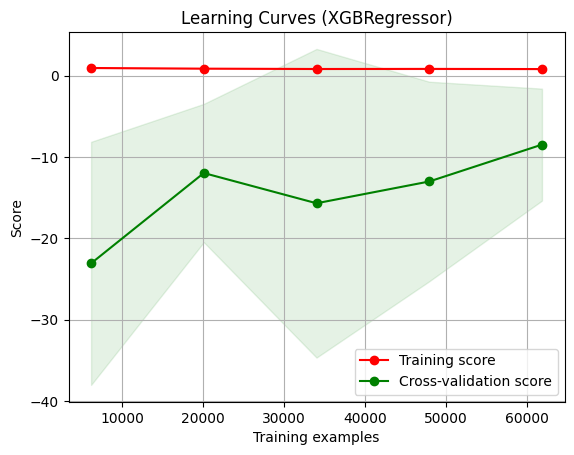

In [23]:

import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time

# Load dataset
df = pd.read_csv('./model_input.csv')

# Select relevant columns
features = ['party_size', 'high_chair_size', 'queue_size', 'month']
categorical_features = ['weekday', 'hour_minute_bin']
target = 'ETA'

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)  # corrected parameter name
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the dataframe
df = pd.concat([df, encoded_features], axis=1)

# Drop original categorical columns
df.drop(categorical_features, axis=1, inplace=True)

# Update feature list to include encoded columns
all_features = features + list(encoded_features.columns)

# Select feature columns and target variable
X = df[all_features]
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'XGBoost Regression': XGBRegressor()
}

# Train and evaluate models
results = {}
times = {}
best_model = None
best_mae = float('inf')
best_model_name = ""

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    elapsed_time = time.time() - start_time
    results[name] = mae
    times[name] = elapsed_time
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_model_name = name  # Store the name of the best model
    print(f'{name} MAE: {mae}, Time: {elapsed_time:.4f} seconds')

# Print results
print("\nModel Performance:")
for name, mae in results.items():
    print(f'{name}: MAE = {mae}, Time = {times[name]:.4f} seconds')

print(f'\nBest Model: {best_model_name} with MAE = {best_mae} and Time = {times[best_model_name]:.4f} seconds')

# Function to prepare user input for prediction
def prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin):
    user_input = pd.DataFrame({
        'party_size': [party_size],
        'high_chair_size': [high_chair_size],
        'queue_size': [queue_size],
        'month': [month]
    })
    
    # One-hot encode categorical features
    user_input_encoded = pd.DataFrame(encoder.transform([[weekday, hour_minute_bin]]), columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate encoded features
    user_input = pd.concat([user_input, user_input_encoded], axis=1)
    
    return user_input

# Get user input
party_size = int(input('Enter party size: '))
high_chair_size = int(input('Enter high chair size: '))
weekday = input('Enter weekday: ')
queue_size = int(input('Enter queue size: '))
month = int(input('Enter month: '))
hour_minute_bin = input('Enter hour minute bin: ')

# Prepare user input
user_input = prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin)

# Predict ETA using the best model
predicted_eta = best_model.predict(user_input)
print(f'Predicted ETA: {predicted_eta[0]}')

# Plot learning curve for the best model
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = f"Learning Curves ({best_model.__class__.__name__})"
plot_learning_curve(best_model, title, X, y, cv=5, n_jobs=-1)
plt.show()


Best XGBoost Model MAE: 0.6857678959612014, Time: 551.0379 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted ETA: 11.117841720581055


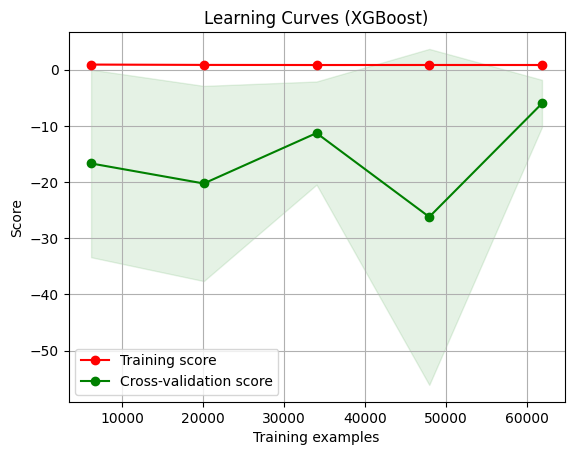

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time

# Load dataset
df = pd.read_csv('./model_input.csv')

# Convert high_chair_size to binary flag
df['high_chair_size'] = df['high_chair_size'].apply(lambda x: 1 if x > 0 else 0)

# Select relevant columns
features = ['party_size', 'high_chair_size', 'queue_size', 'month']
categorical_features = ['weekday', 'hour_minute_bin']
target = 'ETA'

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the dataframe
df = pd.concat([df, encoded_features], axis=1)

# Drop original categorical columns
df.drop(categorical_features, axis=1, inplace=True)

# Update feature list to include encoded columns
all_features = features + list(encoded_features.columns)

# Select feature columns and target variable
X = df[all_features]
y = df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model and parameter grid for GridSearchCV
xgb_model = XGBRegressor()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1]  # L2 regularization
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
elapsed_time = time.time() - start_time

print(f'Best XGBoost Model MAE: {mae}, Time: {elapsed_time:.4f} seconds')

# Function to prepare user input for prediction
def prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin):
    # Convert high_chair_size to binary flag
    high_chair_size_flag = 1 if high_chair_size > 0 else 0
    
    user_input = pd.DataFrame({
        'party_size': [party_size],
        'high_chair_size': [high_chair_size_flag],
        'queue_size': [queue_size],
        'month': [month]
    })
    
    # One-hot encode categorical features
    user_input_encoded = pd.DataFrame(encoder.transform([[weekday, hour_minute_bin]]), columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate encoded features
    user_input = pd.concat([user_input, user_input_encoded], axis=1)
    
    return user_input

# Get user input
party_size = int(input('Enter party size: '))
high_chair_size = int(input('Enter high chair size: '))
weekday = input('Enter weekday: ')
queue_size = int(input('Enter queue size: '))
month = int(input('Enter month: '))
hour_minute_bin = input('Enter hour minute bin: ')

# Prepare user input
user_input = prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin)

# Predict ETA using the best model
predicted_eta = best_model.predict(user_input)
print(f'Predicted ETA: {predicted_eta[0]}')

# Plot learning curve for XGBoost model
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (XGBoost)"
plt = plot_learning_curve(best_model, title, X, y, cv=5, n_jobs=-1)
plt.show()


Validation MAE: 0.8070690256024908
Test MAE: 0.6654290457061246, Time: 439.5729 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


Predicted ETA: 16.297842025756836


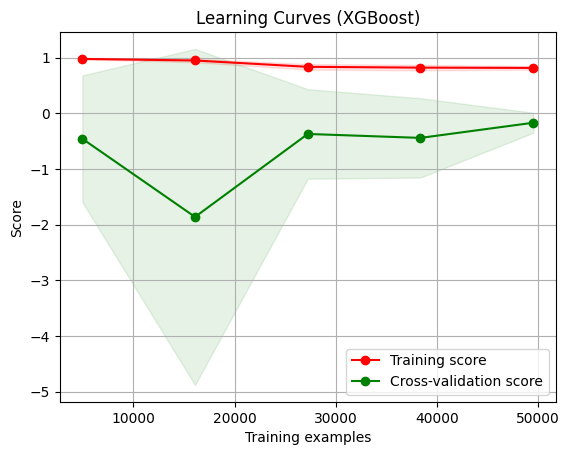

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time

# Load dataset
df = pd.read_csv('./model_input.csv')

# Convert high_chair_size to binary flag
df['high_chair_size'] = df['high_chair_size'].apply(lambda x: 1 if x > 0 else 0)

# Select relevant columns
features = ['party_size', 'high_chair_size', 'queue_size', 'month']
categorical_features = ['weekday', 'hour_minute_bin']
target = 'ETA'

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the dataframe
df = pd.concat([df, encoded_features], axis=1)

# Drop original categorical columns
df.drop(categorical_features, axis=1, inplace=True)

# Update feature list to include encoded columns
all_features = features + list(encoded_features.columns)

# Select feature columns and target variable
X = df[all_features]
y = df[target]

# Split data into training, validation, and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Define XGBoost model and parameter grid for GridSearchCV
xgb_model = XGBRegressor()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1]  # L2 regularization
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {val_mae}')

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
elapsed_time = time.time() - start_time

print(f'Test MAE: {test_mae}, Time: {elapsed_time:.4f} seconds')

# Function to prepare user input for prediction
def prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin):
    # Convert high_chair_size to binary flag
    high_chair_size_flag = 1 if high_chair_size > 0 else 0
    
    user_input = pd.DataFrame({
        'party_size': [party_size],
        'high_chair_size': [high_chair_size_flag],
        'queue_size': [queue_size],
        'month': [month]
    })
    
    # One-hot encode categorical features
    user_input_encoded = pd.DataFrame(encoder.transform([[weekday, hour_minute_bin]]), columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate encoded features
    user_input = pd.concat([user_input, user_input_encoded], axis=1)
    
    return user_input

# Get user input
party_size = int(input('Enter party size: '))
high_chair_size = int(input('Enter high chair size: '))
weekday = input('Enter weekday: ')
queue_size = int(input('Enter queue size: '))
month = int(input('Enter month: '))
hour_minute_bin = input('Enter hour minute bin: ')

# Prepare user input
user_input = prepare_user_input(party_size, high_chair_size, weekday, queue_size, month, hour_minute_bin)

# Predict ETA using the best model
predicted_eta = best_model.predict(user_input)
print(f'Predicted ETA: {predicted_eta[0]}')

# Plot learning curve for XGBoost model
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (XGBoost)"
plt = plot_learning_curve(best_model, title, X_train_full, y_train_full, cv=5, n_jobs=-1)
plt.show()


Validation MAE: 0.8070690256024908
Test MAE: 0.6654290457061246, Time: 510.0133 seconds


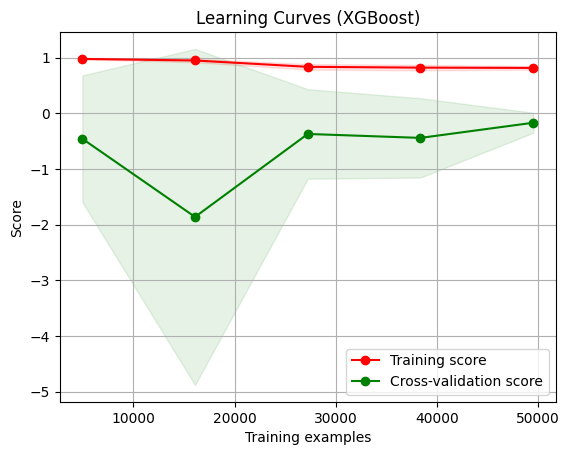

         ETA  predicted_eta     error
0  14.783333       6.135990  8.647343
1  14.366667       6.266728  8.099939
2   2.466667       2.983173 -0.516507
3   1.383333       3.321777 -1.938444
4   0.883333       1.100459 -0.217126


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import time

# Load dataset
df = pd.read_csv('./model_input.csv')

# Define the columns to keep
columns_to_keep = ['reservation_id', 'locaion_id', 'party_size', 'high_chair_size', 'reservation_time', 'weekday', 'ETA', 'queue_size', 'month', 'season', 'hour_minute_bin']

# Keep only the specified columns
df = df[columns_to_keep]

# Convert high_chair_size to binary flag
df['high_chair_size'] = df['high_chair_size'].apply(lambda x: 1 if x > 0 else 0)

# Select relevant columns for features
features = ['party_size', 'high_chair_size', 'queue_size', 'month']
categorical_features = ['weekday', 'hour_minute_bin']
target = 'ETA'

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = pd.DataFrame(encoder.fit_transform(df[categorical_features]), columns=encoder.get_feature_names_out(categorical_features))

# Concatenate encoded features with the dataframe
df = pd.concat([df, encoded_features], axis=1)

# Drop original categorical columns
df.drop(categorical_features, axis=1, inplace=True)

# Update feature list to include encoded columns
all_features = features + list(encoded_features.columns)

# Select feature columns and target variable
X = df[all_features]
y = df[target]

# Split data into training, validation, and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Define XGBoost model and parameter grid for GridSearchCV
xgb_model = XGBRegressor()
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 1]  # L2 regularization
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(xgb_model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAE: {val_mae}')

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
elapsed_time = time.time() - start_time

print(f'Test MAE: {test_mae}, Time: {elapsed_time:.4f} seconds')

# Predict ETA for the entire dataset
df['predicted_eta'] = best_model.predict(X)

# Calculate the error between actual ETA and predicted ETA
df['error'] = df['ETA'] - df['predicted_eta']

# Save the results to a new CSV file
df.to_csv('./model_input_with_predictions.csv', index=False)

# Plot learning curve for XGBoost model
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (XGBoost)"
plt = plot_learning_curve(best_model, title, X_train_full, y_train_full, cv=5, n_jobs=-1)
plt.show()

# Print a few rows of the dataframe with predictions
print(df[['ETA', 'predicted_eta', 'error']].head())


Analysis

In [2]:
import pandas as pd

# Load the data
file_path = './model_input.csv'  # Update this path to your actual CSV file path
data = pd.read_csv(file_path)

# Convert reservation_time to datetime
data['reservation_time'] = pd.to_datetime(data['reservation_time'])

# Filter records where ETA is more than 30 minutes
filtered_data = data[data['ETA'] > 30]

# Display relevant factors
result = filtered_data[['party_size', 'queue_size','weekday', 'hour_minute_bin', 'ETA']]

print(result)


       party_size  queue_size    weekday hour_minute_bin        ETA
385           5.0           6   Saturday     18:15-18:30  30.666667
388           3.0           4   Saturday     18:30-18:45  43.733333
517           8.0           2     Sunday     23:00-23:15  56.750000
518           8.0           2     Sunday     23:00-23:15  56.750000
554           3.0           1    Tuesday     23:30-23:45  79.150000
...           ...         ...        ...             ...        ...
77283         2.0           3  Wednesday     00:45-01:00  40.066667
77287        10.0           1     Friday     00:15-00:30  43.783333
77314         5.0           1  Wednesday     01:15-01:30  35.116667
77320         7.0           1     Friday     00:15-00:30  59.983333
77342         2.0           1  Wednesday     01:30-01:45  52.016667

[652 rows x 5 columns]


In [9]:
# Create a dictionary to store the unique patterns with their ETAs
pattern_dict = filtered_data.groupby(['party_size', 'high_chair_size','queue_size', 'weekday','hour_minute_bin'])['ETA'].apply(list).to_dict()

print(pattern_dict)


{(1.0, 0, 1, 'Friday', '19:00-19:15'): [31.78333333333333], (1.0, 0, 1, 'Monday', '00:00-00:15'): [39.06666666666667], (1.0, 0, 1, 'Monday', '00:15-00:30'): [54.61666666666667], (1.0, 0, 1, 'Saturday', '00:00-00:15'): [31.6], (1.0, 0, 1, 'Saturday', '02:30-02:45'): [46.86666666666667], (1.0, 0, 1, 'Saturday', '16:45-17:00'): [58.96666666666667], (1.0, 0, 1, 'Saturday', '18:00-18:15'): [37.86666666666667], (1.0, 0, 1, 'Saturday', '22:45-23:00'): [168.4], (1.0, 0, 1, 'Sunday', '18:15-18:30'): [60.38333333333333], (1.0, 0, 1, 'Sunday', '22:45-23:00'): [39.61666666666667], (1.0, 0, 1, 'Sunday', '23:00-23:15'): [30.916666666666668, 39.833333333333336], (1.0, 0, 1, 'Thursday', '00:45-01:00'): [124.93333333333334], (1.0, 0, 1, 'Thursday', '16:45-17:00'): [49.1], (1.0, 0, 1, 'Wednesday', '17:30-17:45'): [35.333333333333336], (1.0, 0, 1, 'Wednesday', '21:45-22:00'): [533.9166666666666], (1.0, 0, 1, 'Wednesday', '23:45-24:00'): [30.166666666666668], (1.0, 0, 30, 'Monday', '18:15-18:30'): [53.85]